# Rename chord files

In [40]:
import re
import os
from shutil import copy

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.io import wavfile
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


In [27]:
from chord_rec_lib import delta_t #find_files, format_name

In [12]:
from chord_rec_lib import dnames

HEAD_DIR = '..'
for d in dnames:
    dnames[d] = os.path.join(HEAD_DIR, dnames[d])

In [18]:
ds_downld = pd.read_csv(os.path.join(dnames['CSVS_DIR'], 'downloaded_songlist.csv'), index_col=0)
ds_downld.head()

,artist,duration,number,orig_ds,orig_fname,title,id,href,status,t_eps,raw_song_fname
0,james_brown,151,3.0,Billboard,0003\salami_chords.txt,i_dont_mind,0,NaN,NaN,NaN,NaN
1,roberta_flack_and_donny_hathaway,207,4.0,Billboard,0004\salami_chords.txt,youve_got__friend,1,NaN,NaN,NaN,NaN
2,bette_midler,221,6.0,Billboard,0006\salami_chords.txt,rose,2,NaN,NaN,NaN,NaN
3,billy_joel,318,10.0,Billboard,0010\salami_chords.txt,innocent_man,3,NaN,NaN,NaN,NaN
4,johnny_lee,212,12.0,Billboard,0012\salami_chords.txt,lookin_for_love,4,NaN,NaN,NaN,NaN


In [ ]:
for wav_fname in tqdm_notebook(os.listdir(dnames['WAV_SONGS_DIR'])):
    num = int(re.findall(r'\d+',wav_fname)[0])
    orig_ds = ds_downld.loc[num, 'orig_ds']
    orig_fname = ds_downld.loc[num,'orig_fname']
    new_fname = 'song_{}.lab'.format(num)

    if orig_ds == 'Billboard':
        songs_fname = orig_fname.replace('salami_chords.txt', 'full.lab').replace('\\','/')
        dname_key = 'BB_PARS_DS_DIR'
    elif orig_ds =='chordlib':
        songs_fname = orig_fname.replace('\\', '/')
        dname_key = 'CL_DS_DIR'

    copy(os.path.join(dnames[dname_key], songs_fname),
        os.path.join(dnames['SONGS_PARSED_DIR'], new_fname))

# Split files on chords

## Set chord ds

In [24]:
chord_ds = pd.DataFrame(columns=['song_id', 'fullname', 'starttime', 'endtime'])

In [21]:
for parsed_name in tqdm_notebook(os.listdir(dnames['SONGS_PARSED_DIR'])):
    song_id = int(re.findall(r'\d+', parsed_name)[0])
    with open(os.path.join(dnames['SONGS_PARSED_DIR'], parsed_name)) as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        try:
            stime, etime, fullname = re.split(r'\s', line)
            stime_f, etime_f = map(float, [stime,etime])
            chord_ds = chord_ds.append(
                {'song_id':song_id, 'fullname':fullname, 'starttime':stime_f, 'endtime':etime_f}, ignore_index=True)
        except Exception as e:
            print(line)
            print(e)

FileNotFoundError: [Errno 2] No such file or directory: '../songs_parsed'

In [22]:
chord_ds['chord_id'] = chord_ds.index

In [23]:
chord_ds.head()

,song_id,fullname,starttime,endtime,chord_id


In [144]:
chord_ds.to_csv(os.path.join(dnames['CSVS_DIR'], 'chord_ds.csv'))

## Splitting to distinct files

In [28]:
chord_ds = pd.read_csv(os.path.join(dnames['CSVS_DIR'], 'chord_ds.csv'), index_col=0)
chord_ds.head()

,song_id,fullname,starttime,endtime,chord_id
0,906,N,0.000000,0.628039,0
1,906,E,0.628039,1.064580,1
2,906,A/3,1.064580,1.575419,2
3,906,A:maj(*5),1.575419,2.121088,3
4,906,N,2.121088,2.597097,4


In [29]:
for spectr_fname in tqdm_notebook(os.listdir(os.path.join(dnames['SPECTRS_DIR']))):
    song_id = int(re.findall(r'\d+', spectr_fname)[0])
    sparse = scipy.sparse.load_npz(os.path.join(dnames['SPECTRS_DIR'],spectr_fname))
    
#    for idx, row in tqdm_notebook(chord_ds[chord_ds['song_id']==song_id].iterrows(), 
#                                  total=sum(chord_ds['song_id']==song_id), leave=False):
    for idx, row in chord_ds[chord_ds['song_id']==song_id].iterrows(): 
        sframe, eframe = map(lambda x:int(round(x/delta_t)), [row['starttime'], row['endtime']])
        ch_fname = 'chord_{cid}'.format(cid=row['chord_id'])
        scipy.sparse.save_npz(os.path.join(dnames['CHORDS_DIR'], ch_fname),sparse[:,sframe:eframe])

FileNotFoundError: [Errno 2] No such file or directory: '../../chords/chord_3418.npz'

### Optimal timewidth for a single chord

In [33]:
chord_ds['duration'] = chord_ds['endtime']-chord_ds['starttime']

In [34]:
(chord_ds['duration']/delta_t).sort_values().head()

3450     0.000000
7903     3.317385
6814     9.450679
545     17.205355
2783    22.619807
Name: duration, dtype: float64

In [35]:
chord_ds['duration'].sort_values(ascending=False).head()

4883    91.784000
785     54.341456
7005    47.831000
773     45.705348
2213    42.469402
Name: duration, dtype: float64

In [36]:
xaxis = np.arange(0,0.016849, 0.000001)[1:]

In [37]:
chord_ds['duration'].head()

0    0.628039
1    0.436541
2    0.510839
3    0.545669
4    0.476009
Name: duration, dtype: float64

In [38]:
k = 0.00001
((chord_ds['duration']//k).astype(int)*k).head()

0    0.62803
1    0.43654
2    0.51083
3    0.54566
4    0.47600
Name: duration, dtype: float64

In [41]:
yaxis = np.array([mean_absolute_error(y_pred=(chord_ds['duration']/delta_t//k)*k*delta_t, y_true=chord_ds['duration'])
                 for k in xaxis])

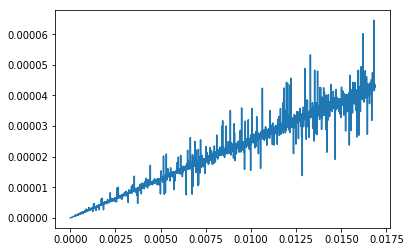

In [42]:
plt.plot(xaxis, yaxis)
plt.show()

In [43]:
chord_ds['duration']/delta_t

0       123.654066
1        85.950187
2       100.578657
3       107.436306
4        93.721008
5       100.578657
6       105.150423
7        91.435125
8        96.006891
9       107.436306
10       98.292774
11       91.435125
12       98.292774
13      102.864540
14      100.578657
15       89.149242
16       64.004725
17      146.296121
18      230.873794
19      146.338059
20      242.261272
21      148.582201
22      251.446545
23      150.868084
24      242.303012
25      158.068517
26      228.244930
27      164.221894
28      231.235086
29      811.759401
           ...    
9744    502.893286
9745    507.465052
9746    505.179169
9747    521.180350
9748    509.750935
9749    518.894467
9750    505.179169
9751    512.036818
9752    332.758220
9753    179.278401
9754    509.750935
9755    516.608584
9756    507.465052
9757    514.322701
9758    500.607403
9759    514.322701
9760    509.750935
9761    516.608584
9762    509.750935
9763    505.179169
9764    505.179169
9765    512.

Optimal coefficient does not exist.
Let's use k=0.005 sec

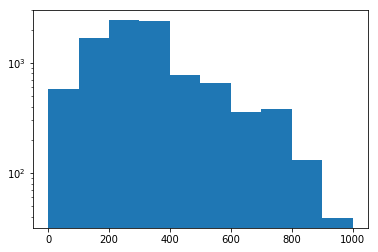

In [44]:
plt.hist((chord_ds['duration']/delta_t)[(chord_ds['duration']/delta_t)<1000], log=True)
plt.show()

In [45]:
k = 10

In [64]:
c_id = 0
X_ds = pd.DataFrame(columns=chord_ds.columns.tolist()+['id'])
cds = chord_ds[100:1000]
for chord_id, row in tqdm_notebook(cds.iterrows(), total=len(cds)):
    chord_fname = 'chord_{}.npz'.format(chord_id)
    chord = scipy.sparse.load_npz(os.path.join(dnames['CHORDS_DIR'], chord_fname))
    
    start_t, end_t = row[['starttime', 'endtime']] 
    for i in range(chord.shape[1]//k):
        c = chord[:,k*i:k*(i+1)]
        c_fname = 'X_{}'.format(c_id)
        st, et = [start_t+delta_t*k*x for x in [i, i+1]]# ]start_t+delta_t*i, start_t+delta_t*(i+1)
        X_ds = X_ds.append(pd.Series({'chord_id':row['chord_id'], 'song_id':row['song_id'], 'starttime':st, 'endtime':et,
                           'fullname':row['fullname'], 'id':c_id, 'duration':et-st},name=c_id))
        c_id +=1
        scipy.sparse.save_npz(os.path.join(dnames['X_DS_DIR'], c_fname), c)
X_ds.head()

,song_id,fullname,starttime,endtime,chord_id,duration,id
0,906,E:(1),119.730158,119.780948,100,0.05079,0
1,906,E:(1),119.780948,119.831738,100,0.05079,1
2,906,E:(1),119.831738,119.882528,100,0.05079,2
3,906,E:(1),119.882528,119.933318,100,0.05079,3
4,906,E:(1),119.933318,119.984108,100,0.05079,4


In [65]:
X_ds.to_csv(os.path.join(dnames['CSVS_DIR'], 'X_ds.csv'))

Conclusion. Songs now divided on sample 10 frames width. Each frame lasts 0.05079 seconds

# Mapping chords

In [67]:
chord_ds['fullname'].nunique()

396

In [178]:
def map_tone(fullnames):
    return [re.findall(r'[A-GN][#b]?', x)[0] for x in fullnames]

def map_majmin(fullnames):
    l = []
    for fn in fullnames:
        if re.fullmatch('[A-G][#b]?(:maj)?', fn):
            l.append('maj')
        elif re.fullmatch('[A-G][#b]?:min', fn):
            l.append('min')
        else:
            l.append(None)
    return l

In [180]:
chord_ds['tone'] = map_tone(chord_ds['fullname'])
chord_ds['majmin'] = map_majmin(chord_ds['fullname'])

In [202]:
chord_ds.to_csv(os.path.join(dnames['CSVS_DIR'], 'chord_ds.csv'))

In [200]:
X_ds['tone'] = map_tone(X_ds['fullname'])
X_ds['majmin'] = map_majmin(X_ds['fullname'])

In [203]:
X_ds.to_csv(os.path.join(dnames['CSVS_DIR'], 'X_ds.csv'))

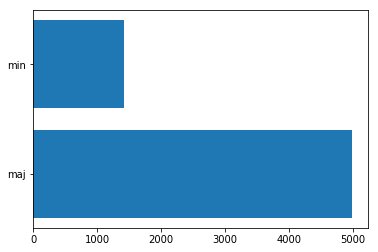

In [196]:
cds = chord_ds.groupby('majmin').count()['chord_id']
plt.barh(y=cds.index, width=cds)
plt.show()